In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [ ]:
# Import dataset
DATADIR = "/content/trainset"
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/folder.zip', 'r') as zip_ref:
    zip_ref.extractall(DATADIR)

CATEGORIES = [
    "aa", "aà", "aá", "aä", "aâ", "abar",
    "ee", "eè", "eé", "eë", "eê", "ebar",
    "ii", "iì", "ií", "iï", "iî", "ibar",
    "oo", "oò", "oó", "oö", "oô", "obar",
    "uu", "uù", "uú", "uü", "uû", "ubar",
]

In [ ]:
# Create training data
IMG_SIZE = 128
training_data = []
def create_train_dataset(dataset,dir,categories):
    for category in categories: 
        path = os.path.join(dir, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path,img), cv2.IMREAD_GRAYSCALE) #Grayscale
            dataset.append([img_array, class_num])
        
create_train_dataset(training_data,DATADIR,CATEGORIES)

aà


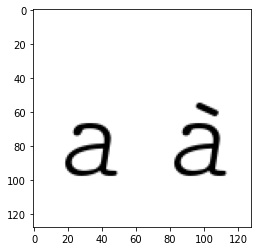

In [ ]:
# Separate images and freatures
x, y = [], []
for features, label in training_data:
    x.append(features)
    y.append(label)
x = np.array(x).reshape(-1,IMG_SIZE,IMG_SIZE,1)

# Normalize data 
x = x/255.0

# print example
x_print = np.reshape(x,(2000,128,128))
plt.imshow(x_print[61],cmap="gray")
print(CATEGORIES[int(y[61])])

In [ ]:
#Model

no_classes = 30

model = keras.models.Sequential([
    keras.Input(shape=(128, 128, 1)),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Conv2D(32, 3, padding="same", activation="relu"),
    layers.MaxPooling2D(2),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128,activation="relu"),
    layers.Dense(no_classes, activation='softmax'),
])

model.summary()

# Compilation, adam optimizer
model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9

In [ ]:
# We know this line doesn't make much sense, but apparently it won't work without it
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=1)
y_train = np.asarray(y_train)
y = np.asarray(y)
print(x.shape,x_train.shape)
print(y.shape,y_train.shape)

# Model Fit

history = model.fit(x_train, y_train, epochs=100, validation_split = 0.3, shuffle=True)

#history = model.fit(x, y, epochs=100, validation_split = 0.3, shuffle=True)

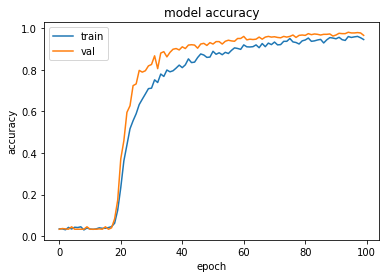

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()

In [ ]:
# Import testset
with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/testset.zip', 'r') as zip_ref:
    zip_ref.extractall("/content")

with zipfile.ZipFile('/content/gdrive/My Drive/Colab Notebooks/model.zip', 'r') as zip_ref:
    zip_ref.extractall("/content")

!mv /content/content/final.model /content/final.model
!rm -r /content/content


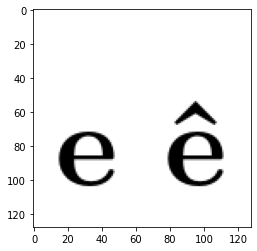

In [ ]:
testset_dir = '/content/images_test'
IMG_SIZE = 128
test_data = []
def create_test_dataset(dataset,path):
    for img in range(5000):
        img_array = cv2.imread(os.path.join(path,f"test_image_{img:05}.png"), cv2.IMREAD_GRAYSCALE) #Grayscale
        dataset.append(img_array)
        
create_test_dataset(test_data,testset_dir)
x_test = np.array(test_data).reshape(-1,IMG_SIZE,IMG_SIZE,1)
x_test = x_test/255.0

# print example
x_print = np.reshape(x_test,(5000,128,128))
plt.imshow(x_print[1],cmap="gray")

In [ ]:
# Load model
# When given the testset we'll uncomment this line
model = keras.models.load_model("/content/final.model")
#x_test = x # comment this when testset is available
#y_test = y # comment this when testset is available
prediction = model.predict(np.asarray(x_test))

"""
x_print = np.reshape(x,(2000,128,128))
f, axarr = plt.subplots(3,2) 
num,num2 = 0,0
"""


errors = 0
filename = 'test_predictions.csv'
with open(filename,'w') as out_file:
    out_file.write('"id","values"\n')
    for image in range(5000):
        out_file.write(f'"{image:05}","{CATEGORIES[np.argmax(prediction[image])]}"\n')

"""
        if CATEGORIES[np.argmax(prediction[image])] != CATEGORIES[y_test[image]]:
            #plt.imshow(x_print[image],cmap="gray")
            print(image)
            print("Prediction: ",CATEGORIES[np.argmax(prediction[image])])
            print("Actual character: ",CATEGORIES[y_test[image]])
            axarr[num][num2].imshow(x_print[image],cmap="gray")
            if num == 2:
                num2 = 1
                num = 0
            else:
                num += 1
            errors += 1
print(errors)
"""

'\n        if CATEGORIES[np.argmax(prediction[image])] != CATEGORIES[y_test[image]]:\n            #plt.imshow(x_print[image],cmap="gray")\n            print(image)\n            print("Prediction: ",CATEGORIES[np.argmax(prediction[image])])\n            print("Actual character: ",CATEGORIES[y_test[image]])\n            axarr[num][num2].imshow(x_print[image],cmap="gray")\n            if num == 2:\n                num2 = 1\n                num = 0\n            else:\n                num += 1\n            errors += 1\nprint(errors)\n'

In [ ]:
# change for testset with results when available
x_test = x
y_test = y
model.evaluate(x_test,  y_test, verbose=2)

63/63 - 0s - loss: 0.0667 - accuracy: 0.9885


[0.06666839122772217, 0.9884999990463257]

In [ ]:
# to be able to save files
from google.colab import files

In [ ]:
# Save the model
model.save("final.model")

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: final.model/assets


In [ ]:
!zip -r /content/model.zip /content/final.model

  adding: content/final.model/ (stored 0%)
  adding: content/final.model/variables/ (stored 0%)
  adding: content/final.model/variables/variables.data-00000-of-00001 (deflated 18%)
  adding: content/final.model/variables/variables.index (deflated 69%)
  adding: content/final.model/assets/ (stored 0%)
  adding: content/final.model/saved_model.pb (deflated 90%)


In [ ]:
files.download('model.zip') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>